# Laboratorio 10

# Task 1 - Práctica

## 1. Librerías

In [26]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from DQN import DQN
import numpy as np

In [27]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Crear entorno de CartPole

In [28]:
env = gym.make("CartPole-v1")

## 3. Definir Redes en línea y de destino

In [29]:
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

In [30]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [31]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

## 4. Establecer hiperparámetros

In [32]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

## 5. Defina la selección de acciones epsilon-greedy

In [33]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## 6. Defina la reproducción de la experiencia

In [34]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    def get_all(self):
        return self.memory

In [35]:
memory = ReplayMemory(10000)

## 7. Ciclo de entrenamiento

In [36]:

steps_done = 0
episode_durations = []
rewards_episode = []

In [37]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [38]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [39]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [11:04<00:00,  1.33s/it]


Complete


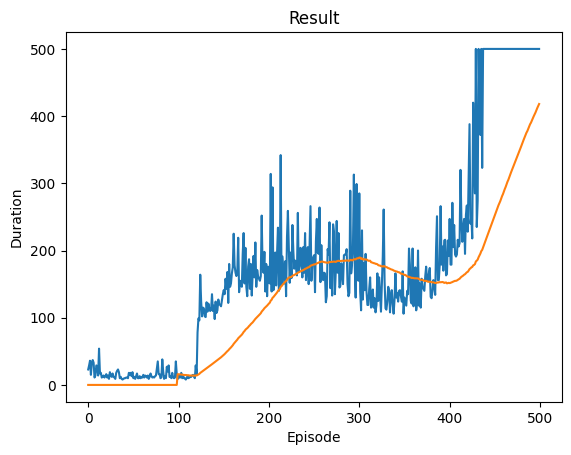

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [40]:
def train():
    if torch.cuda.is_available():
        num_episodes = 500
    else:
        num_episodes = 50

    for i_episode in tqdm(range(num_episodes)):
        sum_reward = 0
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            sum_reward += reward.cpu().numpy()[0]
            done = terminated or truncated

            if terminated:
                next_state = None
                rewards_episode.append(sum_reward)
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model()

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                break
    env.close()

train()
torch.save(policy_net.state_dict(), 'cartpole_dqn.pth')
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

## 8. Representar el entorno

In [41]:
env = gym.make("CartPole-v1", render_mode='human')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
loaded_model = DQN(n_observations, n_actions).to(device)
loaded_model.load_state_dict(torch.load('cartpole_dqn.pth'))
loaded_model.eval()  # Set the model to evaluation mode


DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

## 9. Supervisión del entrenamiento

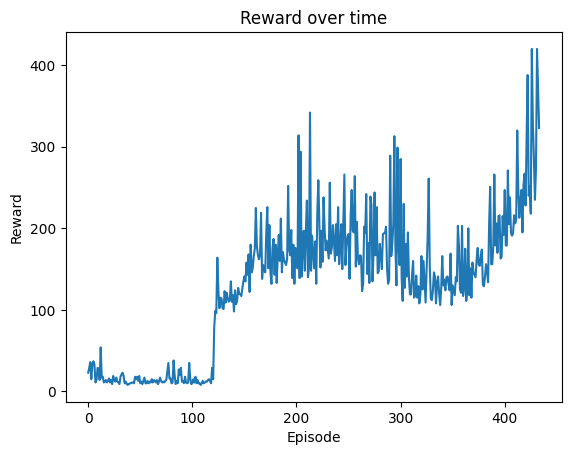

In [42]:
# Crear el gráfico
plt.plot(rewards_episode)
plt.title('Reward over time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


## 10. Evaluar el rendimiento

In [43]:
loaded_model = DQN(n_observations, n_actions).to(device)
loaded_model.load_state_dict(torch.load('cartpole_dqn.pth'))
loaded_model.eval()  # Set the model to evaluation mode

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [44]:

def evaluate_model(model, episodes=1):
    for i in range(episodes):
        tiempo = 600
        env = gym.make("CartPole-v1", render_mode='human')
        
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False
        while not done:
            with torch.no_grad():
                action = model(state).max(1)[1].view(1, 1)
            next_state, _, done, _, _ = env.step(action.item())
            env.render()  # Render the environment to visualize it
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            tiempo -= 1
            if tiempo == 0:
                print(f'Time out! Muy buen modelo no se cayó modelo')
                done = True
                
        env.close()


evaluate_model(loaded_model)

Time out! Muy buen modelo no se cayó modelo


## 11. Fine-tuning

Para este tipo de modelaciones en las cuales no se cuentan con una metrica de desempeño como tal, es necesario juzgar el desempeño del modelo en base a la visualización de la simulación. En este caso el modelo tiene un desemepño casi impecable, a veces pareciera que no se mueve, pero en realidad tiene pequeños movimientos. Un pequeño error que nos llevo a ver su exelente desempeño fue que al momento de evaluar el modelo, este se mostro por más de 15 minutos pues este nunca terminaba (el palo no caia). Para poder continuar con el laboratorio fue necesario agregarle una cantidad limite de acciones para forzar la simulación. Por esta razón no es necesario hacer fine-tuning al modelo pues este ya tiene un desempeño muy bueno. Se adjunta un video para poder verlo en acción.

Link: **https://drive.google.com/file/d/134eahnLIG3RlEnXJW0bcsEchTz-DJNKe/view?usp=drive_link**

# Task 2 - Teoría

### Proximal Policy Optimization

Proximal Policy Optimization (PPO) es un algoritmo de optimización para entrenar agentes en problemas de aprendizaje por refuerzo profundo. La idea principal detrás de PPO es mejorar la política del agente de manera segura y estable. En lugar de realizar grandes actualizaciones de política que pueden ser inestables, PPO limita las actualizaciones de políticas a un rango "proximal" para evitar cambios demasiado drásticos. 

Es útil en una variedad de problemas de aprendizaje por refuerzo, especialmente en entornos donde las recompensas son escasas o es difícil encontrar un buen equilibrio entre la exploración y la explotación.

### Deep Deterministic Policy Gradients (DDPG)

Es un algoritmo de aprendizaje por refuerzo profundo diseñado para problemas de control continuo, donde las acciones son valores continuos en lugar de discretos. DDPG combina la idea de DPG (Deterministic Policy Gradients) con métodos de aprendizaje profundo para entrenar redes neuronales que pueden predecir acciones continuas directamente.

Es adecuado para problemas donde las acciones son continuas y el espacio de acción es de alta dimensionalidad. Ejemplos de tales problemas incluyen robótica, control de vehículos autónomos y cualquier otra aplicación donde las acciones son representadas mejor como valores continuos.

### Trust Region Policy Optimization (TRPO)

Es un algoritmo de aprendizaje por refuerzo que busca mejorar las políticas de decisión de un agente para maximizar su recompenza acumulada a lo largo del tiempo, mientras que mantiene las actualizaciones de la política dentro de una región de confianza para evitar cambios drásticos y potencialmente perjudiciales.

Es adecuado para problemas como robótica, con tareas como locomoción y manipulación de objetos, juegos con espacios de acción complejos y continuos y entornos simulados para probar y desarrollar políticas antes de implementarlas en el mundo real, entre otras. Es computacionalmente costoso y sensible a hiperparámetros.

### Asynchronous Advantage Actor-Critic (A3C)

Es un algoritmo que combina ideas de aprendizaje por refuerzo profundo, aprendizaje basado en actores-críticos y computación asíncrona para lograr buenos resultados de manera eficiente. A3C utiliza una arquitectura de actor-crítico, donde el "actor" se encarga de seleccionar acciones y el "crítico" evalúa las acciones seleccionadas para determinar qué tan buenas son. 

Se puede aplicar en areas como los juegos, desde juegos de Atari hasta juegos 3D complejos, locomoción de robots y manipulación de objetos, entornos virtuales y la investicación de herramientas de aprendizaje por refuerzo.
